# Baseball Pitch Classification
Author: Junwoo Choi


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import sklearn
# print(np.__version__)
# print(pd.__version__)
# print(matplotlib.__version__)
# print(sns.__version__)
# print(mglearn.__version__)
# print(sklearn.__version__)

## 0. Function definitions

In [3]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
   
    scores = cross_validate(model, X, y, cv=cv, return_train_score=True,scoring = scoring)

    mean_train = np.mean(scores["train_score"])
    mean_valid = np.mean(scores["test_score"])

    return mean_train, mean_valid

In [4]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    
    print("Best parameters:")
    print(grid_search.best_params_)

    print("training score = {:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]))
    print("validation score = {:.3f}".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [5]:
def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [6]:
from sklearn.decomposition import PCA

def get_n_principal_components(X, n=2):
    '''Extracts n principal componets from feature matrix X using sklearn PCA.
        X (pandas.DataFrame): A feature matrix
        n (int): number of principal components
        
        returns: feature matrix with n columns as numpy.array
    '''
    #find n principal components from feature matrix
    model = PCA(n)
    model.fit(X)

    #find feature matrix with n columns
    X_2D = model.transform(X)
    print(model.explained_variance_ratio_)
    
    return X_2D

## 1. Load the data

### 1.1 Load raw data

In [7]:
df_pitches = pd.read_csv("../csv_files/2019_pitches_parsed_split.csv")
df_atbats = pd.read_csv("../csv_files/2019_atbats_parsed_split.csv")

In [8]:
display(df_pitches)

px    pz  start_speed  end_speed  break_angle  break_length  break_y  \
0      0.00  2.15         88.8       80.7         22.8           4.8     24.0   
1      0.34  2.31         89.9       81.8         22.8           3.6     24.0   
2     -0.05  2.03         85.7       79.6          9.6           6.0     24.0   
3      0.49  0.92         85.4       78.5         24.0           7.2     24.0   
4     -0.13  1.11         84.6       77.6         26.4           8.4     24.0   
...     ...   ...          ...        ...          ...           ...      ...   
9996   0.16  4.52         95.2       87.3         32.4           4.8     24.0   
9997   1.03  2.29         94.5       86.5         33.6           6.0     24.0   
9998   0.46  2.76         94.2       86.3         33.6           6.0     24.0   
9999   0.56  3.39         94.6       86.8         32.4           6.0     24.0   
10000  0.60  2.00         90.5       82.9         33.6           7.2     24.0   

          ax     ay     az  ...   vz0       x    x0       y    y0    z0  \
0      -8.47  28.90 -15.51  ... -6.89  116.97 -1.42  180.81  50.0  6.07   
1      -7.10  28.85 -12.99  ... -7.48  103.93 -1.02  176.34  50.0  6.20   
2       3.65  22.07 -22.64  ... -5.98  118.86 -1.29  183.96  50.0  6.30   
3     -13.77  24.44 -25.74  ... -6.78   98.15 -1.56  214.03  50.0  5.85   
4     -15.99  24.56 -28.36  ... -5.73  121.81 -1.57  208.77  50.0  5.89   
...      ...    ...    ...  ...   ...     ...   ...     ...   ...   ...   
9996  -14.74  29.82 -21.13  ... -0.96  111.07 -0.57  116.67  50.0  6.28   
9997  -16.75  30.39 -21.45  ... -6.42   77.65 -0.65  177.14  50.0  6.11   
9998  -15.20  30.00 -20.36  ... -5.21   99.32 -0.64  164.37  50.0  6.07   
9999  -16.49  29.84 -23.32  ... -3.40   95.62 -0.73   147.2  50.0  6.22   
10000 -17.63  28.31 -23.09  ... -6.20   94.13 -0.50  184.83  50.0  6.10   

       pfx_x  pfx_z  pitch_type       ab_id  
0      -5.07   9.98          FF  2019000001  
1      -4.14  11.18          FF  2019000002  
2       2.30   5.99          SL  2019000002  
3      -8.87   4.14          CH  2019000002  
4     -10.51   2.51          CH  2019000002  
...      ...    ...         ...         ...  
9996   -7.54   5.65          SI  2019002559  
9997   -8.78   5.62          SI  2019002559  
9998   -7.99   6.21          SI  2019002559  
9999   -8.57   4.60          SI  2019002559  
10000 -10.07   5.19          CH  2019002559  

[10001 rows x 24 columns]

In [9]:
display(df_atbats)

ab_id  pitcher_id p_throws
0     2019000001      571666        R
1     2019000002      571666        R
2     2019000003      571666        R
3     2019000004      502239        R
4     2019000005      502239        R
...          ...         ...      ...
2554  2019002555      544931        R
2555  2019002556      544931        R
2556  2019002557      592789        R
2557  2019002558      592789        R
2558  2019002559      592789        R

[2559 rows x 3 columns]

### 1.2 Merge dataframes and drop nan

Because the pitcher throwing arm and pitcher id is not included in the pitches csv data, we need to merge the dataframe where that information exists

In [10]:
df_combined = df_pitches.merge(df_atbats, on = 'ab_id', how = 'left')
display(df_combined)

px    pz  start_speed  end_speed  break_angle  break_length  break_y  \
0      0.00  2.15         88.8       80.7         22.8           4.8     24.0   
1      0.34  2.31         89.9       81.8         22.8           3.6     24.0   
2     -0.05  2.03         85.7       79.6          9.6           6.0     24.0   
3      0.49  0.92         85.4       78.5         24.0           7.2     24.0   
4     -0.13  1.11         84.6       77.6         26.4           8.4     24.0   
...     ...   ...          ...        ...          ...           ...      ...   
9996   0.16  4.52         95.2       87.3         32.4           4.8     24.0   
9997   1.03  2.29         94.5       86.5         33.6           6.0     24.0   
9998   0.46  2.76         94.2       86.3         33.6           6.0     24.0   
9999   0.56  3.39         94.6       86.8         32.4           6.0     24.0   
10000  0.60  2.00         90.5       82.9         33.6           7.2     24.0   

          ax     ay     az  ...    x0       y    y0    z0  pfx_x  pfx_z  \
0      -8.47  28.90 -15.51  ... -1.42  180.81  50.0  6.07  -5.07   9.98   
1      -7.10  28.85 -12.99  ... -1.02  176.34  50.0  6.20  -4.14  11.18   
2       3.65  22.07 -22.64  ... -1.29  183.96  50.0  6.30   2.30   5.99   
3     -13.77  24.44 -25.74  ... -1.56  214.03  50.0  5.85  -8.87   4.14   
4     -15.99  24.56 -28.36  ... -1.57  208.77  50.0  5.89 -10.51   2.51   
...      ...    ...    ...  ...   ...     ...   ...   ...    ...    ...   
9996  -14.74  29.82 -21.13  ... -0.57  116.67  50.0  6.28  -7.54   5.65   
9997  -16.75  30.39 -21.45  ... -0.65  177.14  50.0  6.11  -8.78   5.62   
9998  -15.20  30.00 -20.36  ... -0.64  164.37  50.0  6.07  -7.99   6.21   
9999  -16.49  29.84 -23.32  ... -0.73   147.2  50.0  6.22  -8.57   4.60   
10000 -17.63  28.31 -23.09  ... -0.50  184.83  50.0  6.10 -10.07   5.19   

       pitch_type       ab_id  pitcher_id  p_throws  
0              FF  2019000001      571666         R  
1              FF  2019000002      571666         R  
2              SL  2019000002      571666         R  
3              CH  2019000002      571666         R  
4              CH  2019000002      571666         R  
...           ...         ...         ...       ...  
9996           SI  2019002559      592789         R  
9997           SI  2019002559      592789         R  
9998           SI  2019002559      592789         R  
9999           SI  2019002559      592789         R  
10000          CH  2019002559      592789         R  

[10001 rows x 26 columns]

In [11]:
df_combined.dropna(axis = 0, inplace = True)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9971 entries, 0 to 10000
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   px            9971 non-null   float64
 1   pz            9971 non-null   float64
 2   start_speed   9971 non-null   float64
 3   end_speed     9971 non-null   float64
 4   break_angle   9971 non-null   float64
 5   break_length  9971 non-null   float64
 6   break_y       9971 non-null   float64
 7   ax            9971 non-null   float64
 8   ay            9971 non-null   float64
 9   az            9971 non-null   float64
 10  sz_bot        9971 non-null   float64
 11  sz_top        9971 non-null   float64
 12  vx0           9971 non-null   float64
 13  vy0           9971 non-null   float64
 14  vz0           9971 non-null   float64
 15  x             9971 non-null   object 
 16  x0            9971 non-null   float64
 17  y             9971 non-null   object 
 18  y0            9971 non-null

### 1.3 Extract only right handed pitchers

Either we can separate the data by throwing arm, or "mirror" the features of left handed pitchers so it matches with right handed. In this case only right handed pitchers are selected.

In [12]:
df_combined['p_throws'] = df_combined['p_throws'].astype('str')
df_combined_right = df_combined[df_combined['p_throws'].str.contains("R")]

In [13]:
display(df_combined_right)

px    pz  start_speed  end_speed  break_angle  break_length  break_y  \
0      0.00  2.15         88.8       80.7         22.8           4.8     24.0   
1      0.34  2.31         89.9       81.8         22.8           3.6     24.0   
2     -0.05  2.03         85.7       79.6          9.6           6.0     24.0   
3      0.49  0.92         85.4       78.5         24.0           7.2     24.0   
4     -0.13  1.11         84.6       77.6         26.4           8.4     24.0   
...     ...   ...          ...        ...          ...           ...      ...   
9996   0.16  4.52         95.2       87.3         32.4           4.8     24.0   
9997   1.03  2.29         94.5       86.5         33.6           6.0     24.0   
9998   0.46  2.76         94.2       86.3         33.6           6.0     24.0   
9999   0.56  3.39         94.6       86.8         32.4           6.0     24.0   
10000  0.60  2.00         90.5       82.9         33.6           7.2     24.0   

          ax     ay     az  ...    x0       y    y0    z0  pfx_x  pfx_z  \
0      -8.47  28.90 -15.51  ... -1.42  180.81  50.0  6.07  -5.07   9.98   
1      -7.10  28.85 -12.99  ... -1.02  176.34  50.0  6.20  -4.14  11.18   
2       3.65  22.07 -22.64  ... -1.29  183.96  50.0  6.30   2.30   5.99   
3     -13.77  24.44 -25.74  ... -1.56  214.03  50.0  5.85  -8.87   4.14   
4     -15.99  24.56 -28.36  ... -1.57  208.77  50.0  5.89 -10.51   2.51   
...      ...    ...    ...  ...   ...     ...   ...   ...    ...    ...   
9996  -14.74  29.82 -21.13  ... -0.57  116.67  50.0  6.28  -7.54   5.65   
9997  -16.75  30.39 -21.45  ... -0.65  177.14  50.0  6.11  -8.78   5.62   
9998  -15.20  30.00 -20.36  ... -0.64  164.37  50.0  6.07  -7.99   6.21   
9999  -16.49  29.84 -23.32  ... -0.73   147.2  50.0  6.22  -8.57   4.60   
10000 -17.63  28.31 -23.09  ... -0.50  184.83  50.0  6.10 -10.07   5.19   

       pitch_type       ab_id  pitcher_id  p_throws  
0              FF  2019000001      571666         R  
1              FF  2019000002      571666         R  
2              SL  2019000002      571666         R  
3              CH  2019000002      571666         R  
4              CH  2019000002      571666         R  
...           ...         ...         ...       ...  
9996           SI  2019002559      592789         R  
9997           SI  2019002559      592789         R  
9998           SI  2019002559      592789         R  
9999           SI  2019002559      592789         R  
10000          CH  2019002559      592789         R  

[7432 rows x 26 columns]

### 1.4 Extract feature matrix and target vector

In [14]:
X = df_combined_right.drop(columns = ['pitch_type', 'ab_id', 'pitcher_id', 'p_throws', 'break_y', 'y0'])
y = df_combined_right['pitch_type']
print(X.shape, type(X))
print(y.shape, type(y))

(7432, 20) <class 'pandas.core.frame.DataFrame'>
(7432,) <class 'pandas.core.series.Series'>


## 2. Inspect the data

Feature Explanation    
- px: left/right distance in feet from the middle of the plate of the pitch, oriented to the umpire's perspective (right positive, left negative) as it crosses the plate
- pz: height of the pitch as it crosses the plate
- start_speed: starting speed of the pitch (essentially from pitcher release point)
- end_speed: speed of the pitch at the plate
- break_angle: the angle in degrees from the straight line path of the release point, to where the pitch crosses home plate
- break_length: the greatest distance (in inches) between the trajectory of the pitch at any point 
- ax, ay, az: acceleration of the pitch (in feet per second^2) measured from release
- sz_top: distance in feet from the ground to the top of the current batter's strikezone
- sz_bot: distance in feet from the ground to the bottom of the current batter's strikezone
- vx0, vy0, vz0: speed of the pitch (in feet per second) measured from release
- x0: left/right distance of the pitch in feet measured from release
- z0: height of the pitch in feet measured from release
- pfx_x: the theoretical horizontal movement in inches of the pitch measured from release
- pfx_z: the theoretical vertical movement in inches of the pitch measured from release

Source: https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/

Because we have quite a few features, before starting the machine learning it would be a good idea to see if any of the features are correlated. From intuition, things like acceleration and velocity should be highly correlated so including both features into the pipeline would probably be redundant. Similarily, we only want features that influence the ball's flight path so features like where the ball started/ended are not needed.

### 2.1 Feature correlation

[Text(0.5, 1.0, 'Pearson Correlation Heatmap for Baseball Pitch Features')]

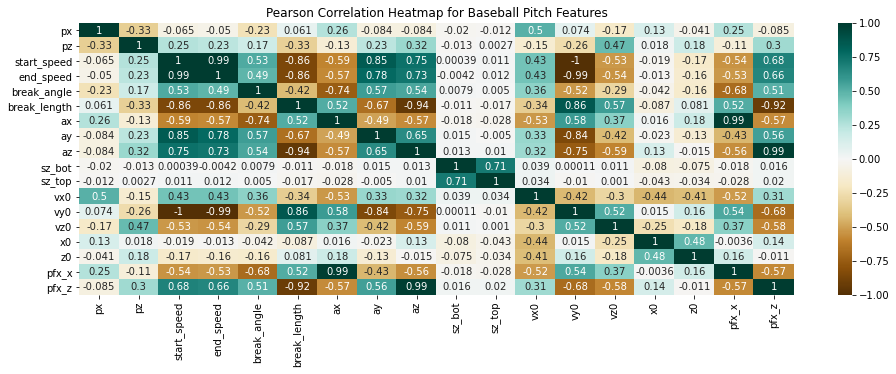

In [15]:
plt.figure(figsize=(16,5))
sns.heatmap(X.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap = 'BrBG').set(title = "Pearson Correlation Heatmap for Baseball Pitch Features")

As we can see from the Pearson correlation heatmap, there are some features which are highly correlated (such as start and end speed). Because of this, only a select amount of features will be included. Features that also have no impact on the flight path of the ball such as sz_bot/sz_top will be removed.  
Features kept: \['start_speed', 'break_angle', 'break_length', 'vx0', 'vz0']

### 2.2 Checking for class imbalance

Target vector    
- FF: four seam fastball
- SL: slider
- CH: changeup
- FT: two seam fastball
- CU: curveball
- SI: sinker
- FC: cutter
- KC: knuckle curve
- FS: splitter
- EP: eephus

In [16]:
y.value_counts()

FF    2756
SL    1311
CH     862
FT     609
CU     602
SI     497
FC     404
KC     259
FS     129
EP       3
Name: pitch_type, dtype: int64

As we can see there are some classes that are under-represented. One solution would be to oversample the minority classes, however for this project the bottom classes will be removed from the dataset (EP, FS and KC)

In [17]:
to_drop = ['KC', 'FS', 'EP']
df_combined_right = df_combined_right[~df_combined_right['pitch_type'].isin(to_drop)]
X = df_combined_right[['start_speed', 'break_angle', 'break_length', 'vx0', 'vz0']]
y = df_combined_right['pitch_type']

[Text(0.5, 1.0, 'Pearson Correlation Heatmap for Baseball Pitch Features')]

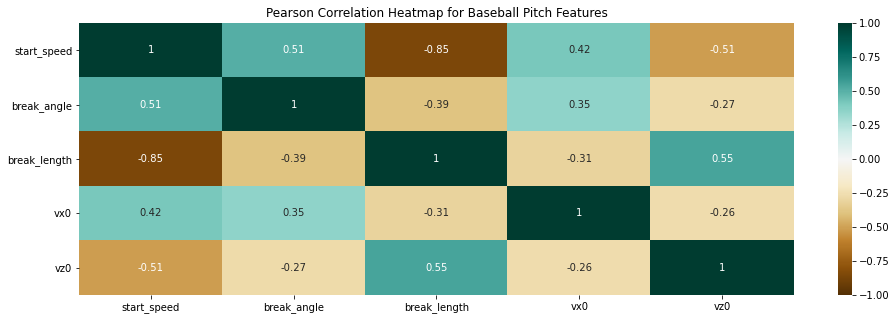

In [18]:
# final correlation heatmap
plt.figure(figsize=(16,5))
sns.heatmap(X.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap = 'BrBG').set(title = "Pearson Correlation Heatmap for Baseball Pitch Features")

## 3. Preprocessing

### 3.1 Label encoding

Due to the target vector being in a string, LabelEncoder is used to convert it into an integer

In [19]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
label_enc.fit(y)
y_enc = label_enc.transform(y)

print(y_enc)
print(label_enc.classes_)

[3 3 6 ... 5 5 0]
['CH' 'CU' 'FC' 'FF' 'FT' 'SI' 'SL']


## 4. Create training and test sets

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, random_state=37, test_size=0.2)

4.1 Scaling feature matrix to training data

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Compare models using cross-validation

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

model_list = [LogisticRegression(), SVC(), GaussianNB(), RandomForestClassifier(random_state=55), GradientBoostingClassifier(random_state=56)]
scores = []

for model in model_list:
    train_score, valid_score = get_classifier_cv_score(model, X_train, y_train, scoring = 'f1_weighted')
    scores.append([valid_score, train_score])

In [23]:
for score, model in sorted(list(zip(scores, model_list)), reverse = True):
    print(model, "train_score = {:.3f}".format(score[1]), "validation_score = {:.3f}".format(score[0]))

GradientBoostingClassifier(random_state=56) train_score = 0.863 validation_score = 0.785
RandomForestClassifier(random_state=55) train_score = 1.000 validation_score = 0.785
SVC() train_score = 0.780 validation_score = 0.767
LogisticRegression() train_score = 0.709 validation_score = 0.707
GaussianNB() train_score = 0.703 validation_score = 0.700


## 6. Hyperparameter tuning using grid search 

From the cross validation experiment, the 3 promising models are GBC, RF and SVC. Now we will tune the parameters through a grid search

### 6.1 Random forest grid search

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [300, 500, 700, 1000],
             'max_depth': [7, 9, 11, 13, 15, 17]
             }

grid_rfr = GridSearchCV(RandomForestClassifier(random_state=55), param_grid, cv=7, scoring = 'f1_weighted', n_jobs= 4, return_train_score= True)

In [25]:
grid_rfr.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [7, 9, 11, 13, 15, 17],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='f1_weighted')

In [26]:
print_grid_search_result(grid_rfr)

Best parameters:
{'max_depth': 13, 'n_estimators': 1000}
training score = 0.966
validation score = 0.790


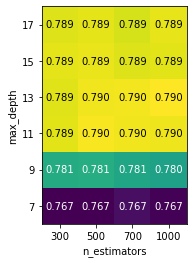

In [27]:
plot_grid_search_results(grid_rfr)

### 6.2 Gradient boosted trees grid search

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [25, 50, 100, 200],
             'learning_rate': [0.001, 0.01, 0.1, 1.0]
             }

grid_gbc = GridSearchCV(GradientBoostingClassifier(max_depth=5, random_state=56), param_grid, cv=7, scoring = 'f1_weighted', n_jobs= 4, return_train_score= True)

In [29]:
grid_gbc.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [25, 50, 100, 200]},
             return_train_score=True, scoring='f1_weighted')

In [30]:
print_grid_search_result(grid_gbc)

Best parameters:
{'learning_rate': 0.1, 'n_estimators': 100}
training score = 0.985
validation score = 0.785


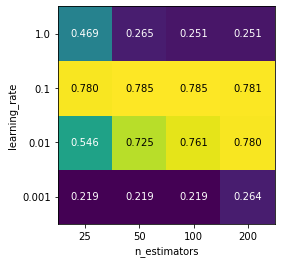

In [31]:
plot_grid_search_results(grid_gbc)

### 6.3 SVC grid search

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.1, 1, 10, 100]
             }

grid_svc = GridSearchCV(SVC(), param_grid, cv=7, scoring = 'f1_weighted', n_jobs= 4, return_train_score= True)

In [33]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='f1_weighted')

In [34]:
print_grid_search_result(grid_svc)

Best parameters:
{'C': 10, 'gamma': 1}
training score = 0.878
validation score = 0.777


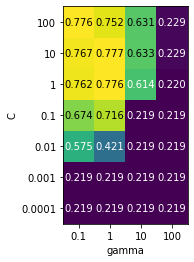

In [35]:
plot_grid_search_results(grid_svc)

## 7. Retrain models on best hyper parameters

In [36]:
rf = RandomForestClassifier(max_depth = 13, n_estimators = 1000, random_state=56)
gbc = GradientBoostingClassifier(max_depth = 5, learning_rate = 0.1, n_estimators = 100, random_state = 56)
svc = SVC(C = 10, gamma = 1, random_state=56)
models = [rf, gbc, svc]

In [37]:
for model in models:
    model.fit(X_train, y_train)

## 8. Evaluate on test data

## Results

In [38]:
from sklearn.metrics import classification_report

for model in models:
    print(model)
    print(classification_report(y_test, model.predict(X_test)))

RandomForestClassifier(max_depth=13, n_estimators=1000, random_state=56)
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       151
           1       0.84      0.81      0.83       106
           2       0.40      0.29      0.34        73
           3       0.89      0.94      0.92       558
           4       0.55      0.43      0.49       129
           5       0.59      0.53      0.56       103
           6       0.78      0.84      0.81       289

    accuracy                           0.79      1409
   macro avg       0.69      0.67      0.67      1409
weighted avg       0.77      0.79      0.78      1409

GradientBoostingClassifier(max_depth=5, random_state=56)
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       151
           1       0.83      0.86      0.84       106
           2       0.39      0.36      0.37        73
           3       0.90      0.95      0.93       558
  

## Interpretation

We can see from the results that the 3 classifiers are quite similar. Their weighted F1 scores are 0.78, 0.78 and 0.76 for RF, GBC and SVC respectively. Similarily, they seem to be able to classify changeups, curveballs, four seam fastballs and sliders \[0, 1, 3, 6] quite well. This makes sense as these pitches are generally quite distinct between other pitches and their "break" is quite different compared to each other. On the other hand, the model has a hard time classifying cutters, two seam fastballs and sinkers \[2, 4, 5]. This also makes sense as these 3 pitches are much harder to distinguish, especially against other pitchers. One pitchers's two seam fastball may be called a sinker for another pitcher (as these 2 pitches use a very similar grip) and cutters in general are a slight variation of a four seam fastball.

## 9. Visualizing the data

Now that we have our models, we can visualize their predictions

### 9.1 PCA 2 Features

In [39]:
X_2D = get_n_principal_components(X)

[0.79852458 0.14006035]


Our first 2 PCA components account for around 94% of the explained variance

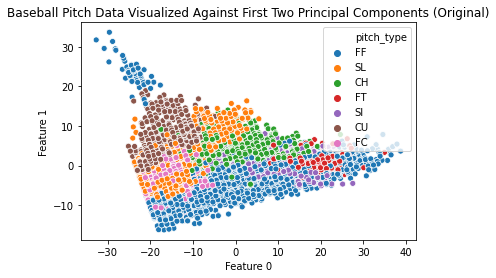

In [40]:
# original data

sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue=y).set_title("Baseball Pitch Data Visualized Against First Two Principal Components (Original)");
plt.xlabel("Feature 0");
plt.ylabel("Feature 1");

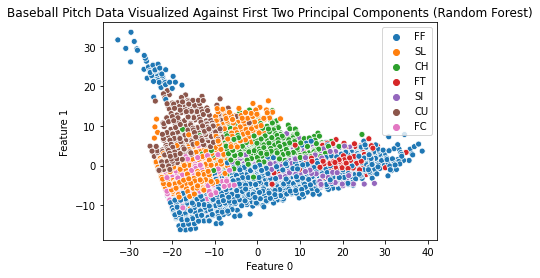

In [41]:
# random forest

y_2 = label_enc.inverse_transform((models[0].predict(scaler.transform(X))))
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue= y_2).set_title("Baseball Pitch Data Visualized Against First Two Principal Components (Random Forest)");
plt.xlabel("Feature 0");
plt.ylabel("Feature 1");

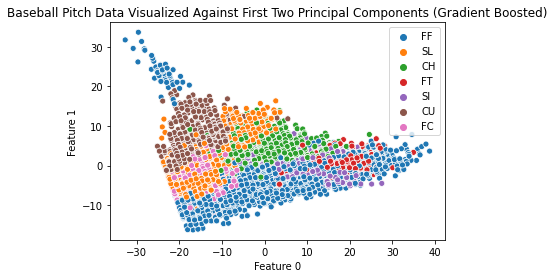

In [42]:
# gradient boosted classifier

y_3 = label_enc.inverse_transform((models[1].predict(scaler.transform(X))))
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue= y_3).set_title("Baseball Pitch Data Visualized Against First Two Principal Components (Gradient Boosted)");
plt.xlabel("Feature 0");
plt.ylabel("Feature 1");

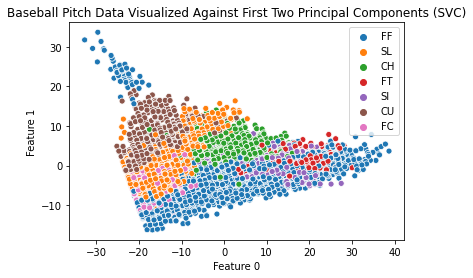

In [43]:
# SVC

y_4 = label_enc.inverse_transform((models[2].predict(scaler.transform(X))))
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue= y_4).set_title("Baseball Pitch Data Visualized Against First Two Principal Components (SVC)");
plt.xlabel("Feature 0");
plt.ylabel("Feature 1");

### 9.2 Visualizing 1 pitcher

Instead of visualizing all the pitch data on one graph, a more interesting approach would be to look at 1 particular pitcher and their arsenal

In [44]:
df_pitches_2 = pd.read_csv("../csv_files/2019_pitches_parsed_split_2.csv")
df_atbats_2 = pd.read_csv("../csv_files/2019_atbats_parsed_split_2.csv")
df_combined_2 = df_pitches_2.merge(df_atbats_2, on = 'ab_id', how = 'left')

# display(df_combined_2)
# df_combined_2.groupby(['pitcher_id']).size()

In [45]:
df_individual = df_combined_2.loc[df_combined_2['pitcher_id'] == 425844]

# display(df_individual)
# df_individual.groupby(['pitch_type']).size()

In [46]:
to_drop = ['KC', 'FS', 'EP']
df_individual = df_individual[~df_individual['pitch_type'].isin(to_drop)]
X_individual = df_individual[['start_speed', 'break_angle', 'break_length', 'vx0', 'vz0']]

In [47]:
from matplotlib.lines import Line2D

thisdict = {
  "CH": "red",
  "CU": "cyan",
  "FF": "green",
  "FT": "blue",
  "SL": "black",
  "SI": "purple",
  "FC": "magenta",
}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='CH', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='CU', markerfacecolor='cyan', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='FF', markerfacecolor='green', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='FT', markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='SL', markerfacecolor='black', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='SI', markerfacecolor='purple', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='FC', markerfacecolor='magenta', markersize=15)
                    ]

By plotting the pitches against their speed, break angle and break length, we can see a clear separation between the pitch types.

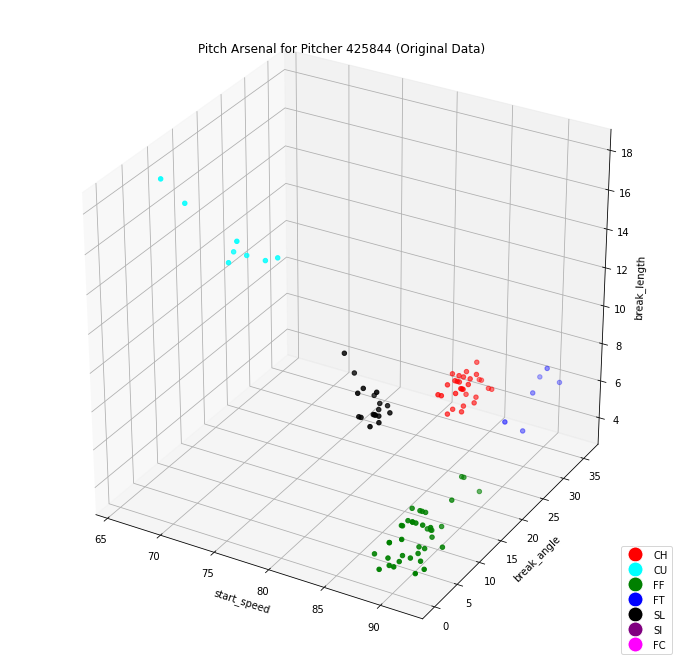

In [48]:
colors= [thisdict[i] for i in list(df_individual['pitch_type'])]

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(df_individual['start_speed'], df_individual['break_angle'], df_individual['break_length'], c = colors);
ax.set_xlabel('start_speed');
ax.set_ylabel('break_angle');
ax.set_zlabel('break_length');
ax.set_title('Pitch Arsenal for Pitcher 425844 (Original Data)');
ax.legend(handles=legend_elements, loc= 'lower right');

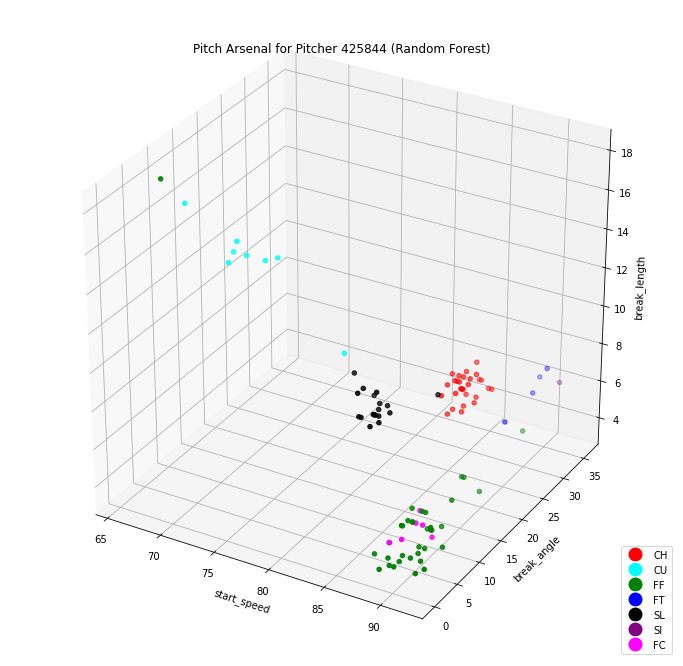

In [49]:
temp = label_enc.inverse_transform((models[0].predict(scaler.transform(X_individual))))
colors= [thisdict[i] for i in temp]

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(df_individual['start_speed'], df_individual['break_angle'], df_individual['break_length'], c = colors);
ax.set_xlabel('start_speed');
ax.set_ylabel('break_angle');
ax.set_zlabel('break_length');
ax.set_title('Pitch Arsenal for Pitcher 425844 (Random Forest)');
ax.legend(handles=legend_elements, loc= 'lower right');

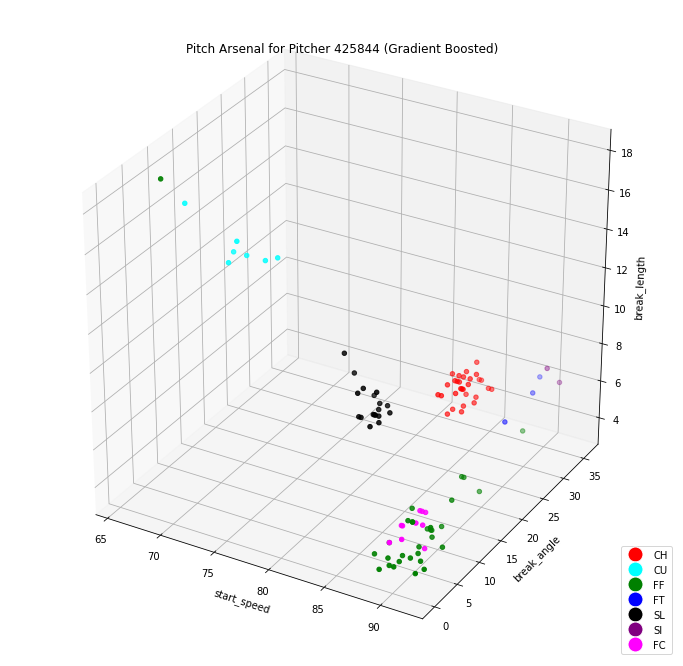

In [50]:
temp = label_enc.inverse_transform((models[1].predict(scaler.transform(X_individual))))
colors= [thisdict[i] for i in temp]

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(df_individual['start_speed'], df_individual['break_angle'], df_individual['break_length'], c = colors);
ax.set_xlabel('start_speed');
ax.set_ylabel('break_angle');
ax.set_zlabel('break_length');
ax.set_title('Pitch Arsenal for Pitcher 425844 (Gradient Boosted)');
ax.legend(handles=legend_elements, loc= 'lower right');

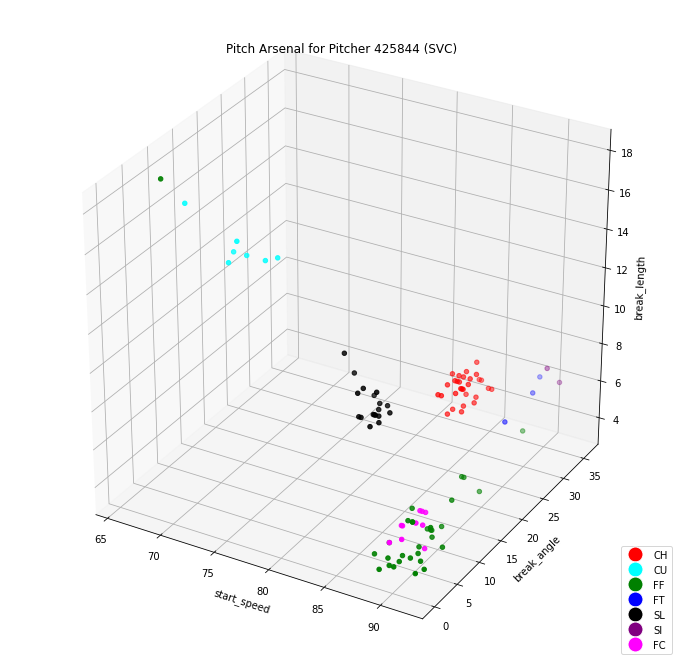

In [51]:
temp = label_enc.inverse_transform((models[1].predict(scaler.transform(X_individual))))
colors= [thisdict[i] for i in temp]

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(df_individual['start_speed'], df_individual['break_angle'], df_individual['break_length'], c = colors);
ax.set_xlabel('start_speed');
ax.set_ylabel('break_angle');
ax.set_zlabel('break_length');
ax.set_title('Pitch Arsenal for Pitcher 425844 (SVC)');
ax.legend(handles=legend_elements, loc= 'lower right');

Our 3d plots agree with our interpretation earlier. In general, changeups, curveballs, sliders and four seam fastballs seem to be easy to classify. However we can see that the classifiers are mislabeling some of the four seam fastballs as cutters which makes sense as these 2 pitches are very similar. Similarly, some of the two seam fastballs are being mislabeled as sinkers as these 2 pitches are also very similar.

## Conclusions

From the machine learning pipeline used, the best models to classify baseball pitches based on their flight features are random forests, gradient boosted classifiers and support vector classifiers, which yielded a weighted f1 score of 0.78, 0.78 and 0.76 respectively (very similar). The easiest pitches to classify were changeups, curveballs, sliders and four seam fastballs as they are quite distinct. The hardest pitches to classify were cutters, two seam fastballs and sinkers as they are variations of each other or to the four seam fastball.  
Some future work include:  
1. Finding additional features/data. Two particular features that were missing from the data were spin rate and spin direction. These could further help in classifying the pitches, especially the tougher ones (cutters/sinkers).  
2. Trying additional classifiers.   
3. Unsupervised learning to find groups of pitches rather than an arbitrary naming scheme.   
4. Neural network clasification.